In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchtext
from torchtext import data, datasets
from torchtext.vocab import Vectors
#from torchtext.data import Field\
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.corpus import stopwords
import numpy as np
import nltk
#nltk.download('all')
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')
from bs4 import BeautifulSoup
from google.colab import drive
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dataset = load_dataset("gigaword")

In [ ]:
train_data = dataset['train']
val_data = dataset['validation']

In [ ]:
df_tr = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)

In [ ]:
df = pd.concat([df_tr, df_val], axis=0)

# Resetting the index after concatenation
df = df.reset_index(drop=True)

# Display the concatenated dataframe
df.head()

,document,summary
0,australia 's current account deficit shrunk by...,australian current account deficit narrows sha...
1,at least two people were killed in a suspected...,at least two dead in southern philippines blast
2,australian shares closed down #.# percent mond...,australian stocks close down #.# percent
3,south korea 's nuclear envoy kim sook urged no...,envoy urges north korea to restart nuclear dis...
4,south korea on monday announced sweeping tax r...,skorea announces tax cuts to stimulate economy


In [ ]:
# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Taking a subset of the data
df = df[0:50000]
df.head()

,document,summary
0,congressional republicans using stalemate arca...,congressional republicans trying build support
1,ministry education youth sport cambodia dispat...,cambodia sends players warm vietnam sea games
2,rebel soldiers loyal central african country f...,rebel soldiers ambush government troops centra...
3,mother rabbinical student killed three years a...,mother slain student assails deportation delay
4,negotiators bellsouth communications workers a...,bellsouth talks wire


In [ ]:
# # Remove non-alphabetic characters (Data Cleaning)
# def text_strip(column):

#     for row in column:
#         row = re.sub("(\\t)", " ", str(row)).lower()
#         row = re.sub("(\\r)", " ", str(row)).lower()
#         row = re.sub("(\\n)", " ", str(row)).lower()

#         # Remove _ if it occurs more than one time consecutively
#         row = re.sub("(__+)", " ", str(row)).lower()

#         # Remove - if it occurs more than one time consecutively
#         row = re.sub("(--+)", " ", str(row)).lower()

#         # Remove ~ if it occurs more than one time consecutively
#         row = re.sub("(~~+)", " ", str(row)).lower()

#         # Remove + if it occurs more than one time consecutively
#         row = re.sub("(\+\++)", " ", str(row)).lower()

#         # Remove . if it occurs more than one time consecutively
#         row = re.sub("(\.\.+)", " ", str(row)).lower()

#         # Remove the characters - <>()|&©ø"',;?~*!
#         row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!#]", " ", str(row)).lower()

#         # Remove mailto:
#         row = re.sub("(mailto:)", " ", str(row)).lower()

#         # Remove \x9* in text
#         row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

#         # Replace INC nums to INC_NUM
#         row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

#         # Replace CM# and CHG# to CM_NUM
#         row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

#         # Remove punctuations at the end of a word
#         row = re.sub("(\.\s+)", " ", str(row)).lower()
#         row = re.sub("(\-\s+)", " ", str(row)).lower()
#         row = re.sub("(\:\s+)", " ", str(row)).lower()

#         # Replace any url to only the domain name
#         try:
#             url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
#             repl_url = url.group(3)
#             row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
#         except:
#             pass

#         # Remove multiple spaces
#         row = re.sub("(\s+)", " ", str(row)).lower()

#         # Remove the single character hanging between any two spaces
#         row = re.sub("(\s+.\s+)", " ", str(row)).lower()

#         yield row

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.replace(" lrb ", "").replace(" rrb ", "")
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
processed_text = df['document'].apply(text_cleaner)
processed_summary = df['summary'].apply(text_cleaner)

In [ ]:
df['document'] = processed_text
df['summary'] = processed_summary

In [ ]:
df.head()

,document,summary
0,congressional republicans using stalemate arca...,congressional republicans trying build support
1,ministry education youth sport cambodia dispat...,cambodia sends players warm vietnam sea games
2,rebel soldiers loyal central african country f...,rebel soldiers ambush government troops centra...
3,mother rabbinical student killed three years a...,mother slain student assails deportation delay
4,negotiators bellsouth communications workers a...,bellsouth talks wire


In [ ]:
df[['summary']].shape

(50000, 1)

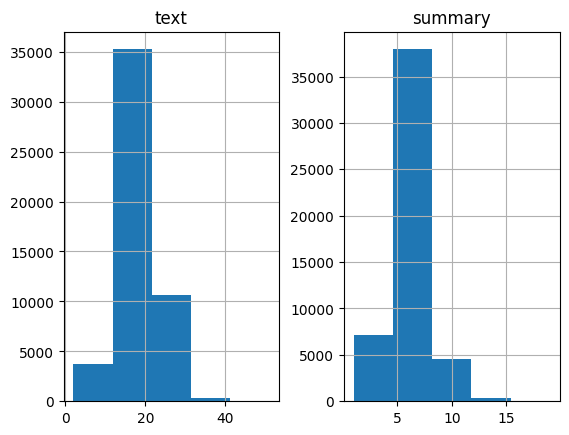

In [ ]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in df['document']:
    text_count.append(len(sent.split()))

for sent in df['summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame()

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [ ]:
graph_df.head()

,text,summary
0,21,5
1,21,7
2,20,8
3,23,6
4,17,3


In [ ]:
# Check how much % of text have 0-30 words
cnt = 0
for i in df['document']:
    if len(i.split()) <= 30:
        cnt = cnt + 1
print(cnt / len(df['document']))

0.99144


In [ ]:
# Check how much % of summary have 0-10 words
cnt = 0
for i in df['summary']:
    if len(i.split()) <= 10:
        cnt = cnt + 1
print(cnt / len(df['summary']))

0.98238


In [ ]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 30
max_summary_len = 10

In [ ]:
import numpy as np

cleaned_text = np.array(df['document'])
cleaned_summary= np.array(df['summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

df.head()

,text,summary
0,congressional republicans using stalemate arca...,congressional republicans trying build support
1,ministry education youth sport cambodia dispat...,cambodia sends players warm vietnam sea games
2,rebel soldiers loyal central african country f...,rebel soldiers ambush government troops centra...
3,mother rabbinical student killed three years a...,mother slain student assails deportation delay
4,negotiators bellsouth communications workers a...,bellsouth talks wire


In [ ]:
# Validating the lengths

text1 =np.array(df['text'])
headline1=np.array(df['summary'])


for i in range(len(text1)):
    if(len(headline1[i].split())>=150):
      print(i)

In [ ]:
df.shape

(48705, 2)

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(df["text"]),
    np.array(df["summary"]),
    test_size=0.3,
    random_state=0,
    shuffle=True,
)

In [ ]:
print(len(x_tr))
print(len(x_val))

34093
14612


In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def readLangs(text, summary, reverse=False):
    print("Reading lines...")

    # Split every line into pairs and normalize
    text=np.array(text)
    summary=np.array(summary)
    pairs = [[text[i],summary[i]] for i in range(len(text))]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(summary)
        output_lang = Lang(text)
    else:
        input_lang = Lang(text)
        output_lang = Lang(summary)

    return input_lang, output_lang, pairs

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name,"--------------------", input_lang.n_words)
    #print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
# Print the vocabulary of input_lang
print("Input Lang Vocabulary:")
print("Number of Words:", input_lang.n_words)
print("Word to Index Mapping:", input_lang.word2index['china'])
print("Index to Word Mapping:", input_lang.index2word[297])

Input Lang Vocabulary:
Number of Words: 34960
Word to Index Mapping: 297
Index to Word Mapping: china


In [ ]:
# Print the vocabulary of output_lang
print("\nOutput Lang Vocabulary:")
print("Number of Words:", output_lang.n_words)
print("Word to Index Mapping:", output_lang.word2index['china'])
print("Index to Word Mapping:", output_lang.index2word[116])


Output Lang Vocabulary:
Number of Words: 20622
Word to Index Mapping: 116
Index to Word Mapping: china


In [ ]:
input_lang, output_lang, pairs = prepareData(x_tr, y_tr , False)

Reading lines...
Read 34093 sentence pairs
Counting words...
Counted words:
['people pakistan went polls thursday elections meant return power civilians three years military rule president pervez musharraf'
 'small study neckties worn doctors new york hospital found almost half ties tested harbored microorganisms could cause illness'
 'malaysia hopes obtain special dogs trained ireland sniff bootlegged dvds part growing efforts combat movie piracy country accused among world top producers illegal discs officials said wednesday'
 ...
 'year old american man charged tuesday allegedly sexually abusing least six girls cambodia court official said'
 'month surgery cleared blockage carotid artery bob barker heading back price right'
 'turkish foreign minister sukru sina gurel pay one day visit jordan next week discuss plans topple regime saddam hussein senior turkish diplomat said friday'] -------------------- 34960


In [ ]:
pairs[5]

['bolivia congress opened marathon session saturday expected result election millionaire businessman gonzalo sanchez lozada president south america poorest country time deep economic crisis social unrest',
 'bolivian congress meets elect president amid economic crisis']

In [ ]:
SOS_token = 0
EOS_token = 1

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
timer = 0
for pair in pairs:
    # Call tensorsFromPair for each pair
    sample_tensors = tensorsFromPair(pair)

    # Print the resulting tensors
    input_tensor, target_tensor = sample_tensors
    print("Input Tensor:")
    print(input_tensor)

    print("\nTarget Tensor:")
    print(target_tensor)

    # Add a separator for better readability
    print("\n" + "=" * 30 + "\n")

    timer += 1
    if timer >= 1:
        break

Input Tensor:
tensor([[ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [ 1]])

Target Tensor:
tensor([[2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [1]])




In [ ]:
def sentenceFromTensor(lang, tensor):
    words = [lang.index2word[index.item()] for index in tensor]
    sentence = ' '.join(words)
    return sentence

# Example tensor
example_tensor = torch.tensor([[2],[3],[4],[5],[6],[7],[1]])

# Convert tensor to sentence using input_lang
original_sentence = sentenceFromTensor(input_lang, example_tensor)

# Print the original sentence
print("Original Sentence:")
print(original_sentence)

Original Sentence:
people pakistan went polls thursday elections EOS


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.LSTM = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.LSTM(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.LSTM = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.LSTM(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
MAX_LENGTH=100

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2 , self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2 , self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.LSTM = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

        #print('Decoder --- atndecoder')

    def forward(self, input, hidden, encoder_outputs):
        #print("inside forward decoder")
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        #print("embedded size", embedded.size())
        #print(embedded[0].size()) #1,300
        #print(hidden[0].size()) # 1, 1, 300
        #print("diff or not")

        #temp = torch.cat((embedded[0], hidden[0]), 1)

        #print(temp)
        #print(temp.size())

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        #print("after getting attn weights softmax")
        #print(attn_weights.size())
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.LSTM(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
#teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    #print('bbbbbbb-->>> input length', input_length)

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        #print("priting before error")
        #print(encoder_output.size())
        #print(encoder_outputs.size())
        temp = encoder_output[0, 0]
        #print(temp)
        encoder_outputs[ei] = temp

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    #Without teacher forcing: use its own predictions as the next input

    #print('aaaaa-->>>')

    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(
      decoder_input, decoder_hidden, encoder_outputs)


      topv, topi = decoder_output.topk(1)

      decoder_input = topi.squeeze().detach()  # detach from history as input

      loss += criterion(decoder_output, target_tensor[di])

      if decoder_input.item() == EOS_token:
             break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def showPlot(train_losses, val_losses=None):
    plt.figure()
    plt.plot(train_losses, label='train')

    if val_losses:
        plt.plot(val_losses, label='validation')

    plt.legend()
    plt.show()

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, val_every=1000):
    print("Training....")
    start = time.time()
    plot_train_losses = []
    plot_val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    val_loss_total = 0  # Reset every val_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        input_length = input_tensor.size(0)
        if input_length > 100:
            continue

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss


        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) Train Loss: %.4f' % (timeSince(start, iter / n_iters),
                                                      iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_train_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_train_losses)




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        #print('cccccc->>>>')

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=5):
    text=list()
    headline=list()
    pred_headline=list()
    for i in range(n):
        pair = random.choice(pairs)

        if(len(pair[0].split())>=100):
          continue
        else:
          if(i%1000==0):
            print(i*100/n,"% complete")

          #print('>', pair[0])
          text.append(pair[0])
          #print('=', pair[1])
          headline.append(pair[1])
          output_words, attentions = evaluate(encoder, decoder, pair[0])
          output_sentence = ' '.join(output_words)
          pred_headline.append(output_sentence)
          #print('<', output_sentence)
          #print('')
    return(text,headline,pred_headline)

In [ ]:
hidden_size = 300
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

losses = trainIters(encoder1, attn_decoder1, 10000, print_every=1000)

Training....
3m 5s (- 27m 53s) (1000 10%) Train Loss: 4.3791
6m 13s (- 24m 52s) (2000 20%) Train Loss: 4.3179
9m 22s (- 21m 53s) (3000 30%) Train Loss: 4.4632
12m 34s (- 18m 52s) (4000 40%) Train Loss: 4.6480
15m 41s (- 15m 41s) (5000 50%) Train Loss: 4.4309
18m 51s (- 12m 34s) (6000 60%) Train Loss: 4.7223


KeyboardInterrupt: ignored

In [ ]:
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [ ]:
text,headline,pred_headline=evaluateRandomly(encoder1, attn_decoder1,11000)

pred_df_LSTM=pd.DataFrame()

pred_df_LSTM['text']=text
pred_df_LSTM['headline']=headline
pred_df_LSTM['pred_headline']=pred_headline

0.0 % complete
6.666666666666667 % complete
13.333333333333334 % complete
20.0 % complete
26.666666666666668 % complete
33.333333333333336 % complete
40.0 % complete
46.666666666666664 % complete
53.333333333333336 % complete
60.0 % complete
66.66666666666667 % complete
73.33333333333333 % complete
80.0 % complete
86.66666666666667 % complete
93.33333333333333 % complete


In [ ]:
for i in range(3,8):
  print("original Summary>>>",pred_df_LSTM.iloc[i]['headline'])
  print("Predicted Summary>>>",pred_df_LSTM.iloc[i]['pred_headline'])
  print('-----------------------------------------------------------------------')

original Summary>>> unk church help million tamales
Predicted Summary>>> china says unk 
-----------------------------------------------------------------------
original Summary>>> aidid faction attacks guerrilla bases
Predicted Summary>>> china says unk 
-----------------------------------------------------------------------
original Summary>>> russia lebanon mull agreement military technical cooperation
Predicted Summary>>> china unk unk 
-----------------------------------------------------------------------
original Summary>>> retailers brace crush holiday buyers
Predicted Summary>>> china says unk 
-----------------------------------------------------------------------
original Summary>>> hong kong moves competitiveness ranking economic giants struggle
Predicted Summary>>> china unk 
-----------------------------------------------------------------------


In [ ]:
pred_df_LSTM.head()

,text,headline,pred_headline
0,italian officials recent criticism policies in...,italian criticism policies highlights distant ...,china says
1,reporter wanted know true abc network home jim...,mystery reporter stirs leno rumors,china says
2,governor william weld leader bursting ideas pr...,weld turns others ideas energize second term,china says
3,hong kong monetary authority monday intervened...,hong kong central bank intervenes defend curre...,china says
4,peruvian justice minister fernando olivera sai...,peru defend stand berenson conviction internat...,china says


In [ ]:
def calculate_rogue(src_trg, pred_trg):

  #cut off  token
  pred_trg = pred_trg[:-6]


  if (len(pred_trg) == 0):
    rogue_score = 0.0
  else:
    s = rouge.get_scores(pred_trg, src_trg, avg= True)
    rogue_score = s['rouge-1']['f']

  return rogue_score


In [ ]:
attn_plot_threshold = 0.45

def evaluateRandomlyprint_1(encoder, decoder, n=5):
    text=list()
    headline=list()
    pred_headline=list()

    for i in range(n):
        pair = random.choice(pairs)

        if(len(pair[0].split())>=150):
          continue
        else:
          #if(i%1000==0):
           # print(i*100/n,"% complete")

          tokenized_input = nltk.word_tokenize(pair[0])
          #print(len(tokenized_input))
          output_words, attentions = evaluate(encoder, decoder, pair[0])

          output_sentence = ' '.join(output_words)

          #get rogue f-score -- need to pass tokenized version here
          #print(pair[0])
          #print(output_sentence)
          score = calculate_rogue(pair[0], output_sentence)
          #if(score>0.25):
           # print(score)

          if score > attn_plot_threshold:
            plot_attention(tokenized_input, output_words, attentions, i)

          #print('<', output_sentence)
          #print('')
    #return(text,headline,pred_headline)

In [ ]:
def plot_attention(sentence, predicted_sentence, attention, i):
  plt.rcParams.update({'font.size': 18})

  fig = plt.figure(figsize=(30,30))

  ax = fig.add_subplot(1,1,1)
  #print(len(attention))
  ax.matshow(attention, cmap='bone')
  #fig.colorbar(cax)
  #fontdict = {'fontsize': 25}

  #ax.set_xticklabels([''] + sentence.split(' ') +[''], rotation=90)
  #ax.set_yticklabels([''] + predicted_sentence)

  ax.set_xticklabels(['']+['']+[t.lower() for t in sentence]+[''], rotation=90)
  ax.set_yticklabels(['']+predicted_sentence)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
  #xlim(right=3)

  plt.show()

In [ ]:
!pip install rouge
import nltk
nltk.download('punkt')
from rouge import Rouge

rouge = Rouge()


evaluateRandomlyprint_1(encoder1, attn_decoder1,15000)
#plt.close()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from collections import Counter
all_text = ' '.join(x_tr)

# Tokenize the text into words
words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Get the most common word
top_10_words = word_counts.most_common(10)

print("Top 10 Most Common Words:")
for word, count in top_10_words:
    print(f"{word}: {count}")

Top 10 Most Common Words:
said: 9097
wednesday: 4306
tuesday: 4230
thursday: 4140
unk: 3869
monday: 3866
friday: 3646
president: 3179
new: 3049
year: 2617


In [ ]:
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=5000)]

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

In [ ]:
text[0]

'remaining tickets saturday fifa women world cup championship rose bowl united states china gobbled monday marla messing president ceo wwc organizing committee announced sell crowd expected record women sporting event'

In [ ]:
summary[0]

'_START_ sellout expected china game _END_'

In [ ]:
df['cleaned_text'] = pd.Series(text)
df['cleaned_summary'] = pd.Series(summary)

In [ ]:
df.head()

,document,summary,cleaned_text,cleaned_summary
0,the remaining tickets for saturday 's #### fif...,sellout expected for u.s.-china game,remaining tickets saturday fifa women world cu...,_START_ sellout expected china game _END_
1,mark webber cruised to his third formula one v...,webber wins british gp after incident with vettel,mark webber cruised third formula one victory ...,_START_ webber wins british incident vettel _END_
2,cricket 's world governing body removed pakist...,icc takes #### world cup from pakistan,cricket world governing body removed pakistan ...,_START_ icc takes world cup pakistan _END_
3,china has acknowledged that a UNK government t...,copper futures trade scandal strikes china,china acknowledged unk government trader place...,_START_ copper futures trade scandal strikes c...
4,britain is likely to announce additional milit...,blair 's office says decision on additional mi...,britain likely announce additional military co...,_START_ blair office says decision additional ...


From the graph and percentage,  95% of the text pieces fall into the 0-40 category

In [ ]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 25
max_summary_len = 11

In [ ]:
import numpy as np

cleaned_text = np.array(df['cleaned_text'])
cleaned_summary= np.array(df['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head()

,text,summary
0,mark webber cruised third formula one victory ...,_START_ webber wins british incident vettel _END_
1,cricket world governing body removed pakistan ...,_START_ icc takes world cup pakistan _END_
2,china acknowledged unk government trader place...,_START_ copper futures trade scandal strikes c...
3,britain likely announce additional military co...,_START_ blair office says decision additional ...
4,unk truce talks israel palestinians making goo...,_START_ bush sees progress israeli palestinian...


In [ ]:
# Add sostok and eostok

post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,mark webber cruised third formula one victory ...,sostok _START_ webber wins british incident ve...
1,cricket world governing body removed pakistan ...,sostok _START_ icc takes world cup pakistan _E...


In [ ]:
post_pre.shape

(10842, 2)

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [ ]:
x_tr[0]

'beijing may xinhua group chinese missile experts said today attack chinese embassy yugoslavia led nato forces premeditated action'

In [ ]:
y_tr[0]

'sostok _START_ chinese missile experts refute nato deceit _END_ eostok'

In [ ]:
# Tokenize the text to get the vocab count
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
x_tokenizer.word_counts

OrderedDict([('beijing', 85),
             ('may', 192),
             ('xinhua', 67),
             ('group', 282),
             ('chinese', 270),
             ('missile', 31),
             ('experts', 43),
             ('said', 2600),
             ('today', 302),
             ('attack', 123),
             ('embassy', 44),
             ('yugoslavia', 26),
             ('led', 122),
             ('nato', 80),
             ('forces', 134),
             ('premeditated', 2),
             ('action', 60),
             ('new', 833),
             ('rules', 28),
             ('buying', 34),
             ('shares', 98),
             ('could', 216),
             ('encourage', 9),
             ('europeans', 1),
             ('invest', 15),
             ('stock', 246),
             ('market', 198),
             ('grow', 14),
             ('pension', 9),
             ('funds', 18),
             ('outside', 39),
             ('home', 167),
             ('markets', 84),
             ('european', 353),


In [ ]:
# Find the percentage of occurrence of rare words (say, occurring less than 2 times) in the text.
thresh = 2

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  45.637685549833385


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 10768


In [ ]:
x_tr.shape

(9757, 25)

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 2

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 49.344709297211715
Size of vocabulary in Y = 5760


In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [ ]:
x_val[0]

array([ 610, 1262,    3,  306,  318, 4550, 1121, 1117,    7,   19,  595,
       1507, 1946,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [ ]:
latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 25, 100)              1076800   ['input_6[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               [(None, 25, 300),            481200    ['embedding_2[0][0]']         
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
77/77 [==============================] - 43s 414ms/step - loss: 5.5908 - val_loss: 4.5809
Epoch 2/50
77/77 [==============================] - 26s 341ms/step - loss: 4.9152 - val_loss: 4.4814
Epoch 3/50
77/77 [==============================] - 23s 304ms/step - loss: 4.7111 - val_loss: 4.1934
Epoch 4/50
77/77 [==============================] - 23s 301ms/step - loss: 4.4762 - val_loss: 4.1356
Epoch 5/50
77/77 [==============================] - 23s 299ms/step - loss: 4.4107 - val_loss: 4.0605
Epoch 6/50
77/77 [==============================] - 22s 284ms/step - loss: 4.3886 - val_loss: 4.0432
Epoch 7/50
77/77 [==============================] - 22s 284ms/step - loss: 4.3738 - val_loss: 4.0585
Epoch 8/50
77/77 [==============================] - 22s 285ms/step - loss: 4.3619 - val_loss: 4.0347
Epoch 9/50
77/77 [==============================] - 22s 284ms/step - loss: 4.3510 - val_loss: 4.0312
Epoch 10/50
77/77 [==============================] - 22s 285ms/step - loss: 4.3402 - val_lo

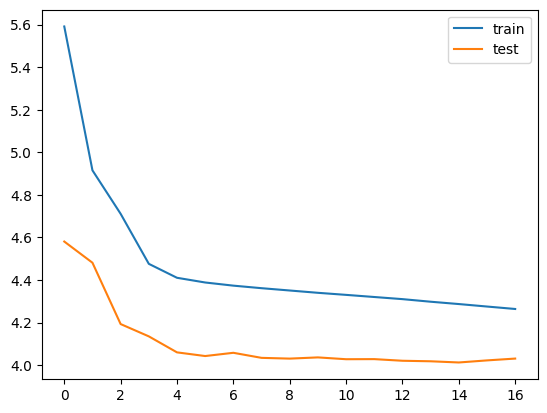

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# Suppose generated_indices is a sequence of indices generated by the model
generated_indices = model.predict([x_val[0:1], np.zeros((1, max_summary_len-1))])
generated_words = [reverse_target_word_index[int(round(idx))]
                   for idx in generated_indices.flatten() if int(round(idx)) in reverse_target_word_index]

# Print the generated sequence
print("Generated Sequence: ", ' '.join(generated_words))


1/1 [==============================] - 1s 733ms/step
Generated Sequence:  end end end end


In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
for i in range(0, 19):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print ('\n')

Review: beijing may xinhua group chinese missile experts said today attack chinese embassy yugoslavia led nato forces premeditated action 
Original summary: start chinese missile experts nato end 
1/1 [==============================] - 1s 546ms/step


1/1 [==============================] - 0s 21ms/step
Predicted summary:  start china president end


Review: new rules buying shares could encourage invest stock market grow pension funds outside home markets european commission said monday 
Original summary: start new rules could encourage europeans buy shares end 
1/1 [==============================] - 0s 20ms/step
Predicted summary:  start china president end


Review: brazil enter world basketball championship japan boosted hard fought loss united states hopeful podium finish 
Original summary: start brazil looking strong finish basketball worlds end 
1/1 [==============================] - 0s 22ms/step
Predicted summary:  start china president end


Review: last month nfl draft one agents representing heisman trophy winner ricky williams said would get client one largest contracts nfl history 
Original summary: start williams say pay later end 
1/1 [==============================] - 0s 19ms/step
Predicted summary:  start china presi

NEW CODE WITH GLOVE

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Assuming you have downloaded the GloVe embeddings (e.g., glove.6B.200d.txt)
glove_file = '/content/drive/MyDrive/glove.6B.100d.txt'
word2vec_text_file = get_tmpfile("glove.6B.100d.word2vec.txt")

# Convert GloVe format to Word2Vec format
glove2word2vec(glove_file, word2vec_text_file)

# Load the Word2Vec format embeddings
glove_model = KeyedVectors.load_word2vec_format(word2vec_text_file, binary=False)


<ipython-input-57-fde86ac50e10>:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_text_file)


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer_glove = Tokenizer(num_words=tot_cnt - cnt)
x_tokenizer_glove.fit_on_texts([str(text) for text in x_tr])


In [ ]:
# Convert text sequences to integer sequences
x_tr_seq_glove = x_tokenizer_glove.texts_to_sequences([str(text) for text in x_tr])
x_val_seq_glove = x_tokenizer_glove.texts_to_sequences([str(text) for text in x_val])


In [ ]:
# Pad zero up to the maximum length
x_tr_glove = pad_sequences(x_tr_seq_glove, maxlen=max_text_len, padding='post')
x_val_glove = pad_sequences(x_val_seq_glove, maxlen=max_text_len, padding='post')


In [ ]:
# Size of vocabulary (+1 for padding token)
x_voc_glove = x_tokenizer_glove.num_words + 1

In [ ]:
# Create a word_index dictionary
word_index_glove = x_tokenizer_glove.word_index

In [ ]:
# Create an embedding matrix
embedding_matrix_glove = np.zeros((x_voc_glove, embedding_dim))

In [ ]:
embedding_matrix_glove.shape

(11360, 100)

In [ ]:
x_tr_glove.shape

(9757, 25)

In [ ]:
for word, index in word_index_glove.items():
    if word in glove_model:
        embedding_matrix_glove[index] = glove_model[word]

In [ ]:
# Prepare a tokenizer for summary data
y_tokenizerglove = Tokenizer(num_words=tot_cnt - cnt)
y_tokenizerglove.fit_on_texts([str(text) for text in y_tr])

# Convert text sequences to integer sequences
y_tr_seqglove = y_tokenizerglove.texts_to_sequences([str(text) for text in y_tr])
y_val_seqglove = y_tokenizerglove.texts_to_sequences([str(text) for text in y_val])

# Pad zero up to the maximum length
y_tr_glove = pad_sequences(y_tr_seqglove, maxlen=max_summary_len, padding='post')
y_val_glove = pad_sequences(y_val_seqglove, maxlen=max_summary_len, padding='post')

# Size of vocabulary for summary data (+1 for padding token)
y_voc_glove = y_tokenizerglove.num_words + 1

# Create a word_index dictionary for summary data
word_index_glove = y_tokenizerglove.word_index

# Create an embedding matrix for summary data
yembedding_matrix_glove = np.zeros((y_voc_glove, embedding_dim))

for word, index in word_index_glove.items():
    if word in glove_model:
        embedding_matrix_glove[index] = glove_model[word]

In [ ]:
latent_dim = 300
embedding_dim = 100

encoder_inputs = Input(shape=(max_text_len, ))
enc_emb = Embedding(
    x_voc_glove,  # Use the new vocabulary size
    embedding_dim,
    weights=[embedding_matrix_glove],
    trainable=False
)(encoder_inputs)


# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 25)]                 0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 25, 100)              1136000   ['input_32[0][0]']            
                                                                                                  
 lstm_30 (LSTM)              [(None, 25, 300),            481200    ['embedding_16[0][0]']        
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                           

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
77/77 [==============================] - 37s 322ms/step - loss: 5.4837 - val_loss: 4.5945
Epoch 2/50
77/77 [==============================] - 22s 289ms/step - loss: 4.9192 - val_loss: 4.5015
Epoch 3/50
77/77 [==============================] - 22s 281ms/step - loss: 4.7693 - val_loss: 4.2475
Epoch 4/50
77/77 [==============================] - 21s 279ms/step - loss: 4.5065 - val_loss: 4.0970
Epoch 5/50
77/77 [==============================] - 21s 275ms/step - loss: 4.4119 - val_loss: 4.0533
Epoch 6/50
77/77 [==============================] - 21s 270ms/step - loss: 4.3799 - val_loss: 4.0300
Epoch 7/50
77/77 [==============================] - 21s 278ms/step - loss: 4.3548 - val_loss: 4.0144
Epoch 8/50
77/77 [==============================] - 22s 280ms/step - loss: 4.3342 - val_loss: 4.0365
Epoch 9/50
77/77 [==============================] - 21s 277ms/step - loss: 4.3164 - val_loss: 4.0047
Epoch 10/50
77/77 [==============================] - 21s 274ms/step - loss: 4.2978 - val_lo

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
for i in range(0, 19):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print ('\n')

Review: beijing may xinhua group chinese missile experts said today attack chinese embassy yugoslavia led nato forces premeditated action 
Original summary: start chinese missile experts nato end 
1/1 [==============================] - 0s 200ms/step
Predicted summary: 


Review: new rules buying shares could encourage invest stock market grow pension funds outside home markets european commission said monday 
Original summary: start new rules could encourage europeans buy shares end 
1/1 [==============================] - 0s 20ms/step
Predicted summary: 


Review: brazil enter world basketball championship japan boosted hard fought loss united states hopeful podium finish 
Original summary: start brazil looking strong finish basketball worlds end 
1/1 [==============================] - 0s 21ms/step
Predicted summary: 


Review: last month nfl draft one agents representing heisman trophy winner ricky williams said would get client one largest contracts nfl history 
Original summary: sta

In [ ]:
# Encode the input sequence to get the feature vector
encoder_inputs = Input(shape=(max_text_len, ))
enc_emb = Embedding(
    x_voc_glove,  # Use the new vocabulary size
    embedding_dim,
    weights=[embedding_matrix_glove],
    trainable=False
)(encoder_inputs)


# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Define the encoder model
encoder_model_glove = Model(encoder_inputs, [encoder_outputs, state_h, state_c])



encoder_model_glove.summary()

# Compile the model
encoder_model_glove.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')



Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 25)]              0         
                                                                 
 embedding_13 (Embedding)    (None, 25, 100)           1136000   
                                                                 
 lstm_25 (LSTM)              [(None, 25, 300),         481200    
                              (None, 300),                       
                              (None, 300)]                       
                                                                 
 lstm_26 (LSTM)              [(None, 25, 300),         721200    
                              (None, 300),                       
                              (None, 300)]                       
                                                                 
 lstm_27 (LSTM)              [(None, 25, 300),         721

In [ ]:
# Decoder
decoder_inputs = Input(shape=(None, ))
dec_emb_layer = Embedding(y_voc_glove, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, _, _) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

decoder_dense = TimeDistributed(Dense(y_voc_glove, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model_glove = Model(
    [decoder_inputs] + [state_h, state_c],
    [decoder_outputs]
)
decoder_model_glove.summary()


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, None, 100)            1136000   ['input_26[0][0]']            
                                                                                                  
 input_27 (InputLayer)       [(None, 300)]                0         []                            
                                                                                                  
 input_28 (InputLayer)       [(None, 300)]                0         []                            
                                                                                           

In [ ]:
# Combine Encoder and Decoder
model_glove = Model([encoder_inputs, decoder_inputs], decoder_model_glove([decoder_inputs] + [state_h, state_c]))

model_glove.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model_glove.summary()


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 25)]                 0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 25, 100)              1136000   ['input_21[0][0]']            
                                                                                                  
 lstm_25 (LSTM)              [(None, 25, 300),            481200    ['embedding_13[0][0]']        
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                           

In [ ]:
history_glove = model_glove.fit(
    [x_tr_glove, y_tr_glove[:, :-1]],
    y_tr_glove.reshape(y_tr_glove.shape[0], y_tr_glove.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val_glove, y_val_glove[:, :-1]],
                     y_val_glove.reshape(y_val_glove.shape[0], y_val_glove.shape[1], 1)[:, 1:])
)


Epoch 1/50
77/77 [==============================] - 38s 346ms/step - loss: 5.7208 - val_loss: 4.7687
Epoch 2/50
77/77 [==============================] - 23s 299ms/step - loss: 5.0137 - val_loss: 4.5749
Epoch 3/50
77/77 [==============================] - 22s 291ms/step - loss: 4.8702 - val_loss: 4.3983
Epoch 4/50
77/77 [==============================] - 23s 293ms/step - loss: 4.6705 - val_loss: 4.2051
Epoch 5/50
77/77 [==============================] - 22s 288ms/step - loss: 4.5166 - val_loss: 4.1096
Epoch 6/50
77/77 [==============================] - 22s 282ms/step - loss: 4.4575 - val_loss: 4.1049
Epoch 7/50
77/77 [==============================] - 22s 283ms/step - loss: 4.4341 - val_loss: 4.0694
Epoch 8/50
77/77 [==============================] - 22s 285ms/step - loss: 4.4205 - val_loss: 4.0762
Epoch 9/50
77/77 [==============================] - 22s 283ms/step - loss: 4.4104 - val_loss: 4.0639
Epoch 10/50
77/77 [==============================] - 22s 283ms/step - loss: 4.4004 - val_lo

In [ ]:
def decode_sequence_glove(input_sequence):
    # Encode the input sequence to get the feature vector
    (e_out, e_h, e_c) = encoder_model_glove.predict(input_sequence)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of the target sequence with the start word
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model_glove.predict([target_seq, e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
for i in range(len(x_val_glove)):
    input_sequence = x_val_glove[i].reshape(1, max_text_len)
    target_summary = y_val_glove[i]  # Assuming y_val_glove contains reference summaries

    # Decode the sequence
    generated_summary = decode_sequence_glove(input_sequence)

    # Print the results
    print(f"Input: {input_sequence}")
    print(f"Reference Summary: {target_summary}")
    print(f"Generated Summary: {generated_summary}\n")

1/1 [==============================] - 0s 34ms/step


ValueError: ignored

In [ ]:
model_glove.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es_glove = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history_glove = model_glove.fit(
    [x_tr_glove, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es_glove],
    batch_size=128,
    validation_data=([x_val_glove, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
)

Epoch 1/50
77/77 [==============================] - 37s 325ms/step - loss: 5.4461 - val_loss: 4.6842
Epoch 2/50
77/77 [==============================] - 22s 290ms/step - loss: 4.9187 - val_loss: 4.4939
Epoch 3/50
77/77 [==============================] - 22s 287ms/step - loss: 4.7514 - val_loss: 4.2418
Epoch 4/50
77/77 [==============================] - 22s 286ms/step - loss: 4.4988 - val_loss: 4.0904
Epoch 5/50
77/77 [==============================] - 22s 281ms/step - loss: 4.4158 - val_loss: 4.0738
Epoch 6/50
77/77 [==============================] - 21s 277ms/step - loss: 4.3916 - val_loss: 4.0537
Epoch 7/50
77/77 [==============================] - 22s 281ms/step - loss: 4.3755 - val_loss: 4.0391
Epoch 8/50
77/77 [==============================] - 22s 281ms/step - loss: 4.3630 - val_loss: 4.0381
Epoch 9/50
77/77 [==============================] - 21s 278ms/step - loss: 4.3532 - val_loss: 4.0407
Epoch 10/50
77/77 [==============================] - 22s 282ms/step - loss: 4.3436 - val_lo

In [ ]:
# Evaluate the model on the validation set
model_glove.evaluate([x_val_glove, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:])


34/34 [==============================] - 1s 27ms/step - loss: 4.0296


4.029584884643555

In [ ]:
# Rest of the code for decoding sequences using the GloVe model
reverse_target_word_index_glove = y_tokenizerglove.index_word
reverse_source_word_index_glove = x_tokenizer_glove.index_word
target_word_index_glove = y_tokenizerglove.word_index


In [ ]:
# Encode the input sequence to get the feature vector
encoder_model_glove = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                          state_h, state_c])


ValueError: ignored